In [1]:
import pandas as pd
import altair as alt
import numpy as np
from pathlib import Path
from helpers import read

import bottleneck as bn
from LPA import Corpus, sockpuppet_distance
from math import floor
from scipy.spatial.distance import cdist, cityblock
import matplotlib.pyplot as plt
from visualize import sockpuppet_matrix, timeline

alt.data_transformers.disable_max_rows()

ImportError: cannot import name 'read' from 'helpers' (/opt/homebrew/lib/python3.11/site-packages/helpers/__init__.py)

### US elections
Regular distribution:

In [9]:
for i, party in enumerate(("DEMOCRAT", "REPUBLICAN")):
    freq = pd.read_csv(f"data/us_elections/np_freq/{i}_normalized.csv")
    cc = freq.pivot_table(
        index="document", columns="element", values="frequency_in_document"
    ).to_numpy()
    cdist_ = cdist(cc, cc, metric="cityblock")
    cdist_[np.triu_indices(len(cdist_), k=1)] = np.nan
    df = pd.DataFrame(
        cdist_,
        index=freq["document"].drop_duplicates(),
        columns=freq["document"].drop_duplicates(),
    )
    df = (
        (df / df.max().max())
        .rename_axis(index="year")
        .melt(ignore_index=False, var_name="year ")
        .dropna()
        .reset_index()
    )
    display(sockpuppet_matrix(df))

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

After TLPA:

In [15]:
from helpers import write

for i, title in enumerate(("Democrat", "Republican")):
    df = pd.read_csv(f"data/us_elections/np_freq/{i}_normalized.csv")
    corpus = Corpus(df)
    dvr = corpus.create_dvr(equally_weighted=True)
    sigs = corpus.create_signatures(distance="JSD", epsilon=1 / (len(dvr) * 2))
    for sig in sigs[0]:
        write(
            Path(f"results/us_elections/sigs/{title.lower()}"),
            sig.to_frame().reset_index().rename(columns={"index": "state"}),
            name=f"us_elections_{sig.name}",
            color=True,
        )

        # configure_legend(
        #     orient="none",
        #     legendX=10,
        #     legendY=50,
        # )
    # display(timeline(
    #     df,
    #     x="document",
    #     y="frequency_in_document",
    #     subcorpus="us_elections",
    #     stack="center",
    #     order=dvr["element"].tolist(),
    #     name=f"{i}",
    # ))
    display(
        sockpuppet_matrix(sockpuppet_distance(corpus, corpus, heuristic=True))
        .properties(title=title)
        .configure_axis(title=None)
    )
    sockpuppet_matrix(sockpuppet_distance(corpus, corpus)).properties(
        title=title
    ).configure_axis(title=None).save(
        f"results/us_elections/{i}_normalized_population.html"
    )

wrote us_elections_1976
wrote us_elections_1980
wrote us_elections_1984
wrote us_elections_1988
wrote us_elections_1992
wrote us_elections_1996
wrote us_elections_2000
wrote us_elections_2004
wrote us_elections_2008
wrote us_elections_2012
wrote us_elections_2016
wrote us_elections_2020


/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():
/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


wrote us_elections_1976
wrote us_elections_1980
wrote us_elections_1984
wrote us_elections_1988
wrote us_elections_1992
wrote us_elections_1996
wrote us_elections_2000
wrote us_elections_2004
wrote us_elections_2008
wrote us_elections_2012
wrote us_elections_2016
wrote us_elections_2020


alt.Chart(...)

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


###

### Death Cause

No missing elements -> no epsilon and no prevelence!

In [16]:
# pick elements
df = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
corpus = Corpus(df)
dvr = corpus.create_dvr(equally_weighted=True)
sigs = corpus.create_signatures(distance="JSD")
full_sig = []
freq_bump = []
top_sig = []

indices = [0, 1, 2, 3, 4, 5]
for i, ix in enumerate(indices):
    full_sig.append(sigs[0][ix])  # .head(10))
    freq_bump.append(df[df["element"].isin(full_sig[i].index)])
    if i > 0:
        full_sig[i] = pd.merge(
            full_sig[i - 1], full_sig[i], left_index=True, right_index=True, how="outer"
        )


def pop_and_melt(l):
    return (
        l.pop()
        .rename_axis(index="cause of death")
        .reset_index()
        .melt(id_vars="cause of death", var_name="year", value_name="distance")
    )  # fillna


sig_specific = pop_and_melt(full_sig)
freq_heads = pd.concat(freq_bump)
# .rename_axis(index="cause of death")
#     .reset_index()
#     .melt(id_vars="cause of death", var_name="year", value_name="distance")
# )
specific = ["HIV/AIDS", "Cardiovascular diseases"]
freq_heads = freq_heads[freq_heads["document"].isin(1990 + np.array(indices))]
specific_freq_heads = freq_heads[freq_heads["element"].isin(specific)]
display(
    alt.Chart(specific_freq_heads)
    .mark_line(point=True)
    .encode(
        x=alt.X("document:O", title="Year"),
        y=alt.Y("frequency_in_document:Q", title="Frequency"),
        color=alt.Color("element:N", title="Cause of Death"),
    )
    .properties(
        title="Causes of Death - Distribution",
        width=300,
        height=200,
    )
)
display(
    alt.Chart(sig_specific[sig_specific["cause of death"].isin(specific)])
    .mark_line(point=True)
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("distance:Q", title="Distance from DVR"),
        color=alt.Color("cause of death:N", title="Cause of Death"),
    )
    .properties(
        title="Causes of Death - Change in Signature",
        width=300,
        height=200,
    )
)

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

alt.Chart(...)

In [17]:
freq_bump = []
top_sig = []

indices = [0, 1, 2]
for i, ix in enumerate(indices):
    full_sig.append(sigs[0][ix])  # .head(10))
    top_sig.append(sigs[0][ix].head(10))
    freq_bump.append(df[df["element"].isin(full_sig[i].index)])
    if i > 0:
        top_sig[i] = pd.merge(
            top_sig[i - 1], top_sig[i], left_index=True, right_index=True, how="outer"
        )
sig_heads = pop_and_melt(top_sig)
freq_heads = pd.concat(freq_bump)
freq_heads = freq_heads[
    freq_heads["document"].isin(np.array(indices) + 1990)
    & freq_heads["element"].isin(sig_heads["cause of death"])
]


display(
    alt.Chart(freq_heads)
    .mark_line(point=True)
    .encode(
        x=alt.X("document:O", title="Year"),
        y=alt.Y("frequency_in_document:Q", title="Frequency"),
        color=alt.Color("element:N", title="Cause of Death"),
    )
    .properties(
        title="Causes of Death - Distribution",
        width=300,
        height=300,
    )
)
display(
    alt.Chart(sig_heads)
    .mark_line(point=True)
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("distance:Q", title="Distance from DVR"),
        color=alt.Color("cause of death:N", title="Cause of Death"),
    )
    .properties(
        title="Causes of Death - Change in Signature",
        width=300,
        height=300,
    )
)

/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

alt.Chart(...)

In [19]:
df = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
cc = df.pivot_table(
    index="document", columns="element", values="frequency_in_document"
)  # .to_numpy()
df = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
corpus = Corpus(df)
dvr = corpus.create_dvr(equally_weighted=True)
sigs = corpus.create_signatures(distance="KLDe")
spd = sockpuppet_distance(corpus, corpus)
dist_dist = pd.DataFrame(
    cdist(cc, cc, metric="cityblock"),
    index=df["document"].drop_duplicates(),
    columns=df["document"].drop_duplicates(),
)
dist_dist = (
    (dist_dist / dist_dist.max().max())
    .rename_axis(index="Corpus 2")
    .melt(ignore_index=False, var_name="other_year", value_name="dist_dist")
    .reset_index()
)
dist_dist = dist_dist[dist_dist["other_year"] == 1990]
spd = spd[spd["Corpus 1"] == 1990]

# dist_dist.columns
distance_comparison = (
    pd.merge(dist_dist[["Corpus 2", "dist_dist"]], spd[["Corpus 2", "value"]])
    .rename(columns={"Corpus 2": "year", "value": "spd"})
    .melt(id_vars=["year"])
)

display(
    alt.Chart(distance_comparison)
    .mark_line(point=True)
    .encode(
        x=alt.X("year:O", title="Year"),
        y=alt.Y("value:Q", title="Normalized Distance"),
        color=alt.Color("variable:N", title="Method"),
    )
    .properties(
        title="Distance of Signatures/Distributions from 1990",
        width=300,
        height=200,
    )
)

0


/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [15]:
ccdf = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
cc = ccdf.pivot_table(
    index="document", columns="element", values="frequency_in_document"
).to_numpy()
cdist_ = cdist(cc, cc, metric="cityblock")
cdist_[np.triu_indices(len(cdist_), k=1)] = np.nan
ccdf = pd.DataFrame(
    cdist_,
    index=ccdf["document"].drop_duplicates(),
    columns=ccdf["document"].drop_duplicates(),
)
mmdf = (
    (ccdf / ccdf.max().max())
    .rename_axis(index="year")
    .melt(ignore_index=False, var_name="year ")
    .dropna()
    .reset_index()
)
display(sockpuppet_matrix(mmdf))

alt.Chart(...)

In [19]:
aadf = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
aa = aadf.pivot_table(
    index="document", columns="element", values="frequency_in_document"
).to_numpy()
adist_ = cdist(aa, aa, metric="euclidean")
adist_[np.triu_indices(len(adist_), k=1)] = np.nan
aadf = pd.DataFrame(
    adist_,
    index=aadf["document"].drop_duplicates(),
    columns=aadf["document"].drop_duplicates(),
)
amdf = (
    (aadf / aadf.max().max())
    .rename_axis(index="year")
    .melt(ignore_index=False, var_name="year ")
    .dropna()
    .reset_index()
)
display(sockpuppet_matrix(amdf))

alt.Chart(...)

In [14]:
df = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
corpus = Corpus(df)
dvr = corpus.create_dvr(equally_weighted=True)
sigs = corpus.create_signatures(distance="JSD")
sigs[1].to_csv("results/death_cause/top_30_most_changed.csv")
# display(
#     timeline(
#         df,
#         x="document",
#         y="frequency_in_document",
#         title="Cause of death, world",
#         corpus="death_cause",
#         stack="center",
#         order=dvr["element"].tolist(),
#         name=f"1",
#     )
# )
spd = sockpuppet_distance(corpus, corpus, heuristic=False)
display(
    sockpuppet_matrix(spd)
    .properties(title="Cause of death, world")
    .configure_axis(title=None)
)
sockpuppet_matrix(sockpuppet_distance(corpus, corpus)).properties(
    title="Cause of death, world"
).configure_axis(title=None)
# .save(
#     f"results/us_elections/dd_normalized_population", format="svg"
# )

alt.Chart(...)

alt.Chart(...)

In [1]:
edf = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
ecorpus = Corpus(edf)
edvr = ecorpus.create_dvr(equally_weighted=True)
esigs = ecorpus.create_signatures(distance="JSD")
# esigs[1].to_csv("results/death_cause/top_30_most_changed.csv")
# display(
#     timeline(
#         df,
#         x="document",
#         y="frequency_in_document",
#         title="Cause of death, world",
#         corpus="death_cause",
#         stack="center",
#         order=dvr["element"].tolist(),
#         name=f"1",
#     )
# )
spd = sockpuppet_distance(ecorpus, ecorpus, heuristic=False, distance="euclidean")
display(
    sockpuppet_matrix(spd)
    .properties(title="Cause of death, world")
    .configure_axis(title=None)
)
# sockpuppet_matrix(sockpuppet_distance(ecorpus, ecorpus)).properties(
# title="Cause of death, world"
# ).configure_axis(title=None)
# .save(
#     f"results/us_elections/dd_normalized_population", format="svg"
# )

NameError: name 'pd' is not defined

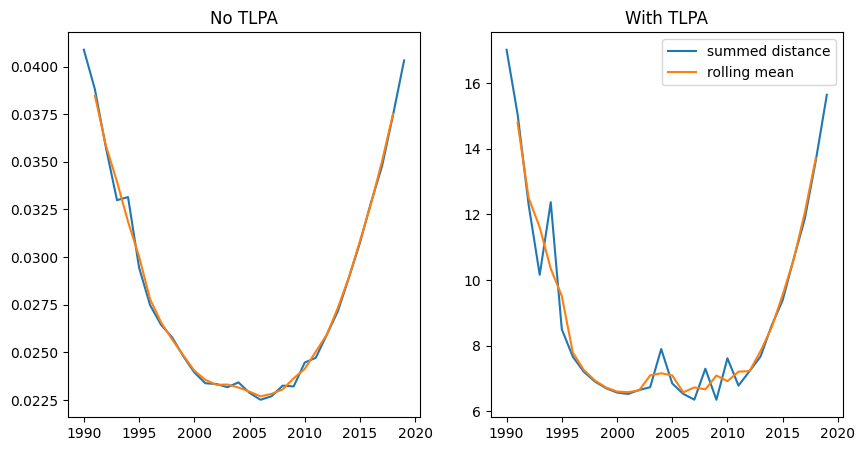

In [16]:
corr = (
    (
        spd.pivot(index="Corpus 1", columns="Corpus 2", values="value").T.fillna(0)
        + spd.pivot(index="Corpus 1", columns="Corpus 2", values="value").fillna(0)
    )
    .sum(axis=1)
    .rename_axis("Year")
)
rolling_mean = corr.rolling(3).mean().shift(-1)
normalized = corr.iloc[2:] - rolling_mean
# (corr.iloc[2:] - rolling_mean).rolling(3).var()
# rolling_mean
ccorr = (ccdf.fillna(0) + ccdf.fillna(0).T).sum(axis=1).rename_axis("Year")
# ccorr.plot()
# print(ccorr)
crolling_mean = ccorr.rolling(3).mean().shift(-1)
# print(crolling_mean)
# crolling_mean.plot()
cnormalized = ccorr - crolling_mean

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # , sharey=True)

ax1.plot(ccorr, label="summed distance")
ax1.plot(crolling_mean, label="rolling mean")

ax1.set_title("No TLPA")

ax2.plot(corr, label="summed distance")
ax2.plot(rolling_mean, label="rolling mean")

ax2.set_title("With TLPA")
plt.legend()
plt.show()

ValueError: could not convert string to float: 'value'

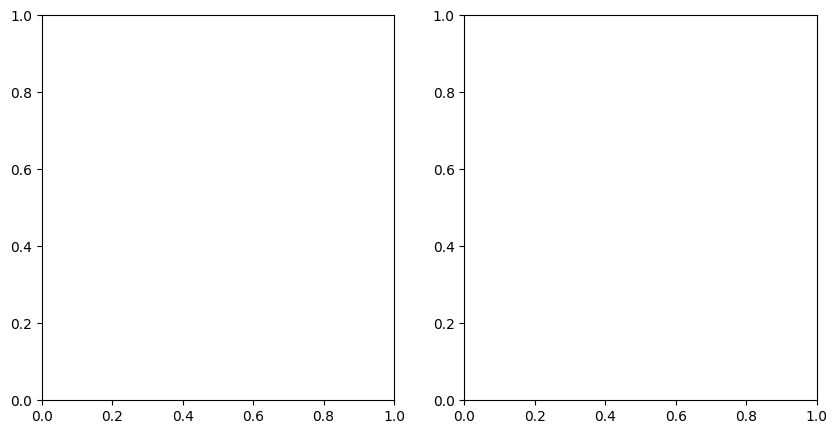

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bnormalized = cnormalized * 1600
ax1.plot(bnormalized, label="normalized")
cstd = bnormalized.std()
ax1.fill_between(bnormalized.index, -cstd, cstd, alpha=0.2)

ax2.plot(normalized, label="normalized")
std = normalized.std()
ax2.fill_between(normalized.index, -std, std, alpha=0.2)

plt.legend()
plt.show()

In [11]:
spd

,Corpus 1,Corpus 2,value
0,1990,1990,0.000000
1,1991,1990,0.115853
2,1992,1990,0.186955
3,1993,1990,0.273898
4,1994,1990,0.466876
...,...,...,...
460,2018,2017,0.072780
461,2019,2017,0.149931
462,2018,2018,0.000000
463,2019,2018,0.078086


### Rank

In [11]:
# for i in range(0, 10):
df = pd.read_csv(f"data/death_cause/np_freq/0_normalized.csv")
corpus = Corpus(df)
dvr = corpus.create_dvr(equally_weighted=True)
sigs = corpus.create_signatures(epsilon=None)
rank = []
indices = [0, 1, 2, 3]
for i, ix in enumerate(indices):
    year = 1990 + ix
    top = (
        sigs[0][ix]
        .head(10)
        .reset_index()
        .reset_index()
        .rename(columns={"index": "cod", "level_0": "rank"})
    )
    top[year] = top[year] < 0
    rank.append(top)
    # rank[i].loc[rank[i][year], "rank"] *= -1
    rank[i].loc[rank[i][year], "rank"] = rank[i].loc[rank[i][year], "rank"].rank() * -1
    rank[i].loc[~rank[i][year], "rank"] = rank[i].loc[~rank[i][year], "rank"].rank()
    if i > 0:
        rank[i] = pd.merge(rank[i - 1], rank[i], on="cod", how="outer")
sig_ranks = (
    rank.pop()
    .melt(id_vars="cod", var_name="year", value_name="rank")
    .dropna(subset=["rank"])
)
display(df)
display(sig_ranks)

# display(pd.concat([x.reset_index() for x in example], axis=1))
# TODO: bump chart
display(sig_ranks)
alt.Chart(sig_ranks).mark_line(point=True).encode(
    x=alt.X("year:O", title="year"), y="rank:O", color=alt.Color("cod:N")
).properties(
    title="Causes of Death",
    width=300,
    height=500,
)
# .transform_window(
#     rank="rank()",
#     sort=[alt.SortField("distance", order="descending")],
#     groupby=["year"],
# )
# display(
#     sockpuppet_matrix(sockpuppet_distance(corpus, corpus))
#     .properties(title="Cause of death, world")
#     .configure_axis(title=None)
# )
# sockpuppet_matrix(sockpuppet_distance(corpus, corpus)).properties(
#     title="Cause of death, world"
# ).configure_axis(title=None).save(
#     f"results/us_elections/{i}_normalized_population.html"
# )

0


/tmp/ipykernel_18201/207541150.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'rank_x'} in the result is deprecated and will raise a MergeError in a future version.
  rank[i] = pd.merge(rank[i - 1], rank[i], on="cod", how="outer")


,document,element,frequency_in_document
0,1990,Acute hepatitis,0.000031
1,1990,Alcohol use disorders,0.000022
2,1990,Alzheimer's disease and other dementias,0.000105
3,1990,Cardiovascular diseases,0.002264
4,1990,Chronic kidney disease,0.000113
...,...,...,...
925,2019,Poisonings,0.000010
926,2019,Protein-energy malnutrition,0.000027
927,2019,Road injuries,0.000155
928,2019,Self-harm,0.000098


,cod,year,rank
0,HIV/AIDS,rank_x,-1.0
1,Diarrheal diseases,rank_x,1.0
2,Lower respiratory infections,rank_x,2.0
3,Nutritional deficiencies,rank_x,3.0
4,Neonatal disorders,rank_x,4.0
...,...,...,...
89,Protein-energy malnutrition,1993,False
90,Neoplasms,1993,True
91,Alzheimer's disease and other dementias,1993,True
93,Tuberculosis,1993,False


,cod,year,rank
0,HIV/AIDS,rank_x,-1.0
1,Diarrheal diseases,rank_x,1.0
2,Lower respiratory infections,rank_x,2.0
3,Nutritional deficiencies,rank_x,3.0
4,Neonatal disorders,rank_x,4.0
...,...,...,...
89,Protein-energy malnutrition,1993,False
90,Neoplasms,1993,True
91,Alzheimer's disease and other dementias,1993,True
93,Tuberculosis,1993,False


/home/alexzabbey/.virtualenvs/tlpa/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)